## Seinfeld - EDA transcripts
**Program:** 01_sfeld_eda.ipynb <br>
**Created by:** Chris Chan<br>
**Date:** Feb 16, 2021<br>
**Purpose:** bring in data, count vectorize, etc. <br>
**Key Features:** 

**Key sites:**<br>
https://letstalkdata.com/2013/06/web-scraping-and-corpus-analysis-with-python-a-seinfeld-case-study/


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF

In [3]:
import glob
import os
from collections import defaultdict
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
import nltk
import os
import spacy
import re
import string
import pickle
from itertools import cycle
import matplotlib.pyplot as plt
from nltk import stem
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic, vis_topic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [5]:
# def processFile(filename):
#     f = open(filename, 'r')
#     content = f.read()
#     content = re.sub('[^A-z \n]','',content)
#     return content.split()

**We read through all the docments and build a list-of-list of words:**

In [6]:
df = pd.read_csv('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj4/data/seinfeld_scripts_clean2.csv')

In [7]:
df.head()

,character,text,episodeno,seid,season
0,JERRY,Do you know what this is all about? Do you kno...,1,S01E01,1
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1,S01E01,1
2,GEORGE,Are you through?,1,S01E01,1
3,JERRY,"You do of course try on, when you buy?",1,S01E01,1
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1,S01E01,1


In [8]:
for text in df["text"][0:10]:
    print(text)

Do you know what this is all about? Do you know, why were here? To be out, this is out and out is one of the single most enjoyable experiences of life. People did you ever hear people talking about We should go out? This is what theyre talking about this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.
(pointing at Georges shirt) See, 

## Data Cleaning

In [9]:
breaks = lambda x: re.sub("\n", " ", x)
alphanumeric = lambda x: re.sub("\w*\d\w*", "", x)
punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x.lower())

In [10]:
df["textmod"] = df["text"].map(breaks).map(alphanumeric).map(punc_lower)
df["character"] = df["character"].str.lower()

In [11]:
df

,character,text,episodeno,seid,season,textmod
0,jerry,Do you know what this is all about? Do you kno...,1,S01E01,1,do you know what this is all about do you know...
1,jerry,"(pointing at Georges shirt) See, to me, that b...",1,S01E01,1,pointing at georges shirt see to me that butto...
2,george,Are you through?,1,S01E01,1,are you through
3,jerry,"You do of course try on, when you buy?",1,S01E01,1,you do of course try on when you buy
4,george,"Yes, it was purple, I liked it, I dont actuall...",1,S01E01,1,yes it was purple i liked it i dont actually r...
...,...,...,...,...,...,...
54593,jerry,Grand theft auto - don't steal any of my jokes.,23,S09E23,9,grand theft auto dont steal any of my jokes
54594,prisoner 3,You suck - I'm gonna cut you.,23,S09E23,9,you suck im gonna cut you
54595,jerry,"Hey, I don't come down to where you work, and ...",23,S09E23,9,hey i dont come down to where you work and kno...
54596,guard,"Alright, Seinfeld, that's it. Let's go. Come on.",23,S09E23,9,alright seinfeld thats it lets go come on


**Attach char to each line if/when summarizing to episode**

In [12]:
df["episodetext"] = df['character']+": "+df["textmod"] 
df.head()

,character,text,episodeno,seid,season,textmod,episodetext
0,jerry,Do you know what this is all about? Do you kno...,1,S01E01,1,do you know what this is all about do you know...,jerry: do you know what this is all about do y...
1,jerry,"(pointing at Georges shirt) See, to me, that b...",1,S01E01,1,pointing at georges shirt see to me that butto...,jerry: pointing at georges shirt see to me tha...
2,george,Are you through?,1,S01E01,1,are you through,george: are you through
3,jerry,"You do of course try on, when you buy?",1,S01E01,1,you do of course try on when you buy,jerry: you do of course try on when you buy
4,george,"Yes, it was purple, I liked it, I dont actuall...",1,S01E01,1,yes it was purple i liked it i dont actually r...,george: yes it was purple i liked it i dont ac...


In [13]:
def tprint(data,var,nobs):
    for text in data[var][0:nobs]:
        print(text)

In [14]:
tprint(df,"episodetext",10)
# for text in df["episodetext"][0:10]:
#     print(text)

jerry: do you know what this is all about do you know why were here to be out this is out and out is one of the single most enjoyable experiences of life people did you ever hear people talking about we should go out this is what theyre talking about this whole thing were all out now no one is home not one person here is home were all out there are people tryin to find us they dont know where we are on an imaginary phone did you ring i cant find him where did he go he didnt tell me where he was going he must have gone out you wanna go out you get ready you pick out the clothes right you take the shower you get all ready get the cash get your friends the car the spot the reservation then youre standing around whatta you do you go we gotta be getting back once youre out you wanna get back you wanna go to sleep you wanna get up you wanna go out again tomorrow right where ever you are in life its my feeling youve gotta go
jerry: pointing at georges shirt see to me that button is in the wor

## Best Seasons only - (4,5,6,7,8)

In [19]:
df = df.loc[df["season"].isin([4,5,6,7,8])]

**Stop Words**

In [ ]:
import spacy
from sklearn import preprocessing 

nlp = spacy.load("en_core_web_sm")

# Define default stopwords list
stoplist = spacy.lang.en.stop_words.STOP_WORDS

def replace_ptbr_char_by_word(word):
    """ Will remove the encode token by token"""
    word = str(word)
    word = preprocessing.normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII')
    return word

def remove_pt_br_char_by_text(text):
    """ Will remove the encode using the entire text"""
    text = str(text)
    text = " ".join(replace_ptbr_char_by_word(word) for word in text.split() if word not in stoplist)
    return text

df['textmod'] = df['textmod'].apply(remove_pt_br_char_by_text)

we want to remove all speaker names that show up at any time

In [21]:
chars1 =df.character.unique()
ch_list = chars1.tolist()

In [22]:
type(ch_list)

list

In [23]:
ch_list

['george',
 'jerry',
 'kramer',
 'studio guard',
 'voice',
 'helena',
 'lt. coleman',
 'lt. martel',
 'security guard',
 'other security guard (to george)',
 'other security guard',
 'receptionist',
 'chelsea',
 'fred savage',
 'fred',
 'fred (a little frightened and backing away towards the door)',
 'george (from the bathroom)',
 'lupe',
 'george (to lupe)',
 'officer',
 'corbin bernsen',
 'george wendt',
 'george wendt (checking his watch, obviously uncomfortable)',
 'announcer',
 'the freak',
 'tv newscaster',
 'man',
 'woman',
 'police',
 'cop',
 'cop 2',
 'cops',
 'jerry and george',
 'guy',
 'police radio',
 'reporters',
 'newscaster',
 'stu',
 'jay',
 'newman',
 'jerry and newman',
 'devola',
 'russell',
 'susan',
 'elaine',
 'dr. reston',
 'tel',
 'leo',
 'newman (satisfied)',
 'russel',
 'police officer',
 'judge',
 'boyfriend',
 'helen',
 'morty',
 'gas station attendant',
 'nurse',
 'all',
 'dr. dembrow',
 "(the episode opens with a series of clips from 'the pitch', 'the tic

In [24]:
rem = str.maketrans('', '', '\@#%&[]();:-""''+,.`*/...')
ch_list2 = [s.translate(rem) for s in ch_list]
ch_list2

['george',
 'jerry',
 'kramer',
 'studio guard',
 'voice',
 'helena',
 'lt coleman',
 'lt martel',
 'security guard',
 'other security guard to george',
 'other security guard',
 'receptionist',
 'chelsea',
 'fred savage',
 'fred',
 'fred a little frightened and backing away towards the door',
 'george from the bathroom',
 'lupe',
 'george to lupe',
 'officer',
 'corbin bernsen',
 'george wendt',
 'george wendt checking his watch obviously uncomfortable',
 'announcer',
 'the freak',
 'tv newscaster',
 'man',
 'woman',
 'police',
 'cop',
 'cop 2',
 'cops',
 'jerry and george',
 'guy',
 'police radio',
 'reporters',
 'newscaster',
 'stu',
 'jay',
 'newman',
 'jerry and newman',
 'devola',
 'russell',
 'susan',
 'elaine',
 'dr reston',
 'tel',
 'leo',
 'newman satisfied',
 'russel',
 'police officer',
 'judge',
 'boyfriend',
 'helen',
 'morty',
 'gas station attendant',
 'nurse',
 'all',
 'dr dembrow',
 "the episode opens with a series of clips from 'the pitch' 'the ticket' and 'thewallet

In [25]:
ids = ",".join(ch_list2) 

In [26]:
type(ids)

str

In [27]:
ch_list3=ids.replace("'","")


In [28]:
ch_list3

'george,jerry,kramer,studio guard,voice,helena,lt coleman,lt martel,security guard,other security guard to george,other security guard,receptionist,chelsea,fred savage,fred,fred a little frightened and backing away towards the door,george from the bathroom,lupe,george to lupe,officer,corbin bernsen,george wendt,george wendt checking his watch obviously uncomfortable,announcer,the freak,tv newscaster,man,woman,police,cop,cop 2,cops,jerry and george,guy,police radio,reporters,newscaster,stu,jay,newman,jerry and newman,devola,russell,susan,elaine,dr reston,tel,leo,newman satisfied,russel,police officer,judge,boyfriend,helen,morty,gas station attendant,nurse,all,dr dembrow,the episode opens with a series of clips from the pitch the ticket and thewallet illustrating the story so far a rough precis would be,naomi,doorman,maitre d,cynthia,reston,davola,elainedavola,elaine oc,kramer oc,davola oc,reston oc,george os,mortyhelenjerry,leo oc,mel,waitress,mrs sanger,donald,man 1,man 2,guy1,sandra,s

In [29]:
ch_list4 = ch_list3.split(",")

In [30]:
ch_list4

['george',
 'jerry',
 'kramer',
 'studio guard',
 'voice',
 'helena',
 'lt coleman',
 'lt martel',
 'security guard',
 'other security guard to george',
 'other security guard',
 'receptionist',
 'chelsea',
 'fred savage',
 'fred',
 'fred a little frightened and backing away towards the door',
 'george from the bathroom',
 'lupe',
 'george to lupe',
 'officer',
 'corbin bernsen',
 'george wendt',
 'george wendt checking his watch obviously uncomfortable',
 'announcer',
 'the freak',
 'tv newscaster',
 'man',
 'woman',
 'police',
 'cop',
 'cop 2',
 'cops',
 'jerry and george',
 'guy',
 'police radio',
 'reporters',
 'newscaster',
 'stu',
 'jay',
 'newman',
 'jerry and newman',
 'devola',
 'russell',
 'susan',
 'elaine',
 'dr reston',
 'tel',
 'leo',
 'newman satisfied',
 'russel',
 'police officer',
 'judge',
 'boyfriend',
 'helen',
 'morty',
 'gas station attendant',
 'nurse',
 'all',
 'dr dembrow',
 'the episode opens with a series of clips from the pitch the ticket and thewallet illu

Since we want to look at episode level we can include names as stopwords

In [31]:
from sklearn.feature_extraction import text 
chars = ['seinfeld','jerry','elaine','george','kramer','newman','morty','helen','frank','peterman','puddy','steinbrenner']
my_stop_words = nltk.corpus.stopwords.words('english')
my_stop_words.extend(chars) #text.ENGLISH_STOP_WORDS.union(chars)
my_stop_words.extend(ch_list4)

In [32]:
my_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [33]:
df.head()
#tprint(df,"textmod2",10)

,character,text,episodeno,seid,season,textmod,episodetext
11196,george,Kramer was on Murphy Brown?,1,S04E01,4,kramer was on murphy brown,george: kramer was on murphy brown
11197,jerry,Yeah.,1,S04E01,4,yeah,jerry: yeah
11198,george,Are you sure?,1,S04E01,4,are you sure,george: are you sure
11199,jerry,Yeah.,1,S04E01,4,yeah,jerry: yeah
11200,george,"Murphy Brown, the TV show.",1,S04E01,4,murphy brown the tv show,george: murphy brown the tv show


## Lemmatize

In [34]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [35]:
df["lemmatized"] = df["textmod"].apply(spacy_lemmatize)
df

<ipython-input-35-fd8cc5396c51>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lemmatized"] = df["textmod"].apply(spacy_lemmatize)


,character,text,episodeno,seid,season,textmod,episodetext,lemmatized
11196,george,Kramer was on Murphy Brown?,1,S04E01,4,kramer was on murphy brown,george: kramer was on murphy brown,kramer be on murphy brown
11197,jerry,Yeah.,1,S04E01,4,yeah,jerry: yeah,yeah
11198,george,Are you sure?,1,S04E01,4,are you sure,george: are you sure,be you sure
11199,jerry,Yeah.,1,S04E01,4,yeah,jerry: yeah,yeah
11200,george,"Murphy Brown, the TV show.",1,S04E01,4,murphy brown the tv show,george: murphy brown the tv show,murphy brown the tv show
...,...,...,...,...,...,...,...,...
47302,kramer,I'd like to get some coffee.,22,S08E22,8,id like to get some coffee,kramer: id like to get some coffee,i d like to get some coffee
47303,george,This was supposed to be 'The summer of George'...,22,S08E22,8,this was supposed to be the summer of george t...,george: this was supposed to be the summer of ...,this be suppose to be the summer of george the...
47304,therapist,"Now, swing them swing swing them, just swing t...",22,S08E22,8,now swing them swing swing them just swing them,therapist: now swing them swing swing them jus...,now swing they swing swing they just swing they
47305,sam,I can't do it. It's hard!,22,S08E22,8,i cant do it its hard,sam: i cant do it its hard,I ca nt do it its hard


### Doc: Episode Level

Create 2 separate ds: 1 with speaker and 1 without speaker

1. with speaker

In [36]:
df_sp = df.copy()

## Doc: Episode Level
df_sp = df_sp.drop(['character','text','textmod','episodeno','lemmatized','season'],axis=1)
# concatenate the string 
df_sp['episodetext'] = df_sp.groupby(['seid'])['episodetext'].transform(lambda x : ' '.join(x)) 

# drop duplicate data 
df_sp = df_sp.drop_duplicates()
  
# show the dataframe 
print(df_sp) 

         seid                                        episodetext
11196  S04E01  george: kramer was on murphy brown jerry: yeah...
11485  S04E02  george: hes on the lamb hes on the loose jerry...
11751  S04E03  george: what did they do for toilet paper in t...
12111  S04E04  jerry: going through couch cushions where the ...
12462  S04E05  jerry: so george and i went up to nbc and we t...
...       ...                                                ...
45813  S08E18  george: oh boy i was up to four in the morning...
46093  S08E19  george: so marcy you shouldve seen me in the h...
46387  S08E20  elaine: uh excuse me gladys: be with you in a ...
46692  S08E21  jerry: hang on just let me pick up a paper man...
46979  S08E22  jerry: nah you had a good run took them to the...

[113 rows x 2 columns]


2. without speaker and removing pronouns 

In [37]:
df_nosp = df.copy()

## Doc: Episode Level
df_nosp = df_nosp.drop(['character','text','textmod','episodetext','episodeno','season'],axis=1)
# concatenate the string 
df_nosp['lemmatized'] = df_nosp.groupby(['seid'])['lemmatized'].transform(lambda x : ' '.join(x)) 

# drop duplicate data 
df_nosp = df_nosp.drop_duplicates()
  
# show the dataframe 
print(df_nosp) 

         seid                                         lemmatized
11196  S04E01  kramer be on murphy brown yeah be you sure yea...
11485  S04E02  he s on the lamb he s on the loose would you l...
11751  S04E03  what do they do for toilet paper in the civil ...
12111  S04E04  go through couch cushion where the hell do I p...
12462  S04E05  so george and I go up to nbc and we tell they ...
...       ...                                                ...
45813  S08E18  oh boy I be up to four in the morning watch th...
46093  S08E19  so marcy you should ve see I in the hot tub yo...
46387  S08E20  uh excuse I be with you in a minute turn she b...
46692  S08E21  hang on just let I pick up a paper excuse I wo...
46979  S08E22  nah you have a good run take they to the world...

[113 rows x 2 columns]


Use the above for topic modeling (df_nosp)

## Manual: Count Vectorizer (term doc matrix)

In [38]:
# input params 

vectorizer = CountVectorizer(stop_words = my_stop_words) #'english')
doc_word = vectorizer.fit_transform(df_nosp.lemmatized)
doc_word.shape

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'absolutely', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'always', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'answering', 'anvino', 'anything', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside', 'asked', 'asking', 'asks', 'assistant', 'associate', 'assorted', 'assume', 'attached', 'attempt', 'attempting', 'aunt', 'away', 'babus', 'back', 'background', 'backing', 'backstage', 'bad', 'bag', 'baines', 'bakersoll', 'banging', 'barneys', 'basket', 'bass', 'bat', 'bathroom', 'bathrooms', 'beach', 'beami

(113, 11862)

In [39]:
pd.DataFrame(doc_word.toarray(),columns=vectorizer.get_feature_names())

,aa,aaa,aaaa,aaaaa,aaaaaaaaaah,aaaaaaahhh,aaaaaah,aaaaaahhh,aaaaah,aaaah,...,zippy,ziti,zombie,zone,zoo,zoology,zoom,zoomin,zorn,zoutraph
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
import csv
with open('stoplist.csv','w') as f:
    write=csv.writer(f)
    write.writerow(my_stop_words)

## Topic Modeling

**Let's start with NMF**

Convert Doc Word to Doc Topic

In [41]:
# define the number of topics you want to reduce to
k=10
nmf_model = NMF(k)

# read lecture on how nmf is working
doc_topic = nmf_model.fit_transform(doc_word)
doc_topic.shape

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


(113, 10)

Now we have 173 episodes and 15 topics 

Convert Doc topic to Topic Word

In [42]:
# basically you have a transposed DF of k topics and n words in your corpus
topic_word = nmf_model.components_
topic_word.shape

(10, 11862)

In [43]:
topic_word

array([[0.00456548, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00088609, 0.        , 0.09567783, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00309369, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00444128, 0.        , 0.        , ..., 0.        , 0.00644002,
        0.00644002],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

We started with ~17k words and now we have 11k which is better

Let's look at the words per document with the highest weights (top k words)

In [44]:
topw=10

# obtain actual topic words that resulted in teh NMF model
words = vectorizer.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-topw:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['nt', 'yeah', 'know', 'get', 'like', 'na', 'gon', 'hey', 'oh'],
 ['nt', 'get', 'go', 'know', 'well', 'see', 'oh', 'ya', 'hey'],
 ['uh', 'yeah', 'alright', 'well', 'oh', 'get', 'know', 'say', 'okay'],
 ['nt', 'go', 'know', 'get', 'like', 'yeah', 'see', 'right', 'uh'],
 ['get', 'go', 'right', 'oh', 'well', 'nt', 'ill', 'want', 'na'],
 ['well', 'yeah', 'hey', 'go', 'oh', 'ah', 'ha', 'know', 'nt'],
 ['look', 'hand', 'get', 'like', 'nt', 'go', 'shirt', 'take', 'yeah'],
 ['well', 'nt', 'think', 'know', 'look', 'tell', 'right', 'come', 'like'],
 ['oh', 'nt', 'see', 'yeah', 'well', 'know', 'like', 'think', 'yes'],
 ['nt', 'get', 'well', 'car', 'go', 'alright', 'see', 'think', 'gon']]

## Automate Topic Modeling

**Trying to udnerstand components of each vectorizer first**

In [45]:
# Fit transform doc word to doc topic        
# vec is your count vectorizer. these are bag of words
#sein.feature_names = vec.get_feature_names()
# putting all feature names into an array
words_array = list(np.asarray(vectorizer.get_feature_names()))

In [46]:
mat_corpus = matutils.Sparse2Corpus(doc_word.transpose())

Looks like sparse2corpus takes our doc word (sparse matrix) and for every document (173 eps) it provides a tuple of (unique word id, count of words). So you will have different unique words per document.

In [47]:
mat_corpus[0]

[(53, 2),
 (54, 1),
 (89, 1),
 (119, 1),
 (122, 1),
 (125, 1),
 (127, 1),
 (129, 2),
 (132, 1),
 (164, 1),
 (184, 1),
 (196, 1),
 (219, 2),
 (225, 2),
 (235, 2),
 (257, 1),
 (263, 2),
 (293, 1),
 (300, 1),
 (316, 1),
 (318, 12),
 (320, 1),
 (322, 1),
 (332, 3),
 (402, 3),
 (419, 2),
 (442, 1),
 (445, 1),
 (447, 1),
 (449, 2),
 (458, 1),
 (530, 1),
 (540, 1),
 (546, 1),
 (561, 1),
 (576, 5),
 (594, 1),
 (650, 2),
 (672, 1),
 (685, 1),
 (693, 2),
 (697, 1),
 (712, 1),
 (733, 2),
 (735, 2),
 (739, 4),
 (741, 1),
 (758, 1),
 (765, 5),
 (782, 1),
 (817, 3),
 (841, 1),
 (846, 1),
 (886, 1),
 (898, 1),
 (901, 2),
 (931, 2),
 (941, 4),
 (949, 2),
 (969, 2),
 (975, 3),
 (983, 1),
 (1012, 4),
 (1066, 2),
 (1069, 1),
 (1070, 6),
 (1093, 1),
 (1111, 1),
 (1123, 1),
 (1133, 2),
 (1199, 1),
 (1238, 1),
 (1251, 2),
 (1261, 2),
 (1269, 3),
 (1280, 1),
 (1282, 1),
 (1283, 1),
 (1317, 1),
 (1347, 4),
 (1380, 1),
 (1402, 1),
 (1409, 1),
 (1419, 1),
 (1431, 1),
 (1437, 2),
 (1455, 3),
 (1462, 2),
 (1463, 

In [48]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

Here we just create a dictionary of word id and the actual word itself

In [49]:
id2word

{6868: 'murphy',
 1347: 'brown',
 11722: 'yeah',
 10119: 'sure',
 9349: 'show',
 1946: 'cmon',
 11688: 'ya',
 4499: 'gun',
 9650: 'something',
 7145: 'nt',
 1531: 'candace',
 969: 'bergen',
 5782: 'know',
 332: 'always',
 6030: 'like',
 8614: 'remember',
 1580: 'carnal',
 5783: 'knowledge',
 1280: 'breast',
 8475: 'really',
 6915: 'naked',
 10811: 'type',
 1467: 'ca',
 941: 'believe',
 6659: 'miss',
 576: 'ask',
 4312: 'go',
 1505: 'california',
 10758: 'turn',
 2015: 'come',
 10319: 'tell',
 5699: 'keep',
 9127: 'secret',
 6994: 'never',
 8515: 'record',
 8172: 'previous',
 5602: 'joni',
 4869: 'hirsch',
 442: 'anybody',
 9516: 'sleep',
 10542: 'together',
 6005: 'lid',
 9124: 'second',
 11395: 'well',
 6129: 'long',
 11346: 'way',
 6422: 'mature',
 4802: 'hey',
 6065: 'listen',
 10562: 'tonight',
 1507: 'call',
 11305: 'want',
 4276: 'give',
 10794: 'two',
 4039: 'free',
 10483: 'ticket',
 5812: 'la',
 11304: 'wanna',
 3615: 'fact',
 2317: 'could',
 10619: 'track',
 3704: 'feel',
 75

**lets export to see what we have**

In [50]:
import csv
def xportwords(id2word):
    with open('idworddict.csv', 'w') as f:
        for key in id2word.keys():
            f.write("%s,%s\n"%(key,id2word[key]))

def xportwfreq(corpus):
    with open('wordfreq.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['name','num'])
        for row in corpus:
            csv_out.writerow(row)

**Define Pipeline**

Let's try defining a pipeline for LMF and word checking

In [51]:
class topic_model():

    def __init__(sein, data, vectorizer, model, num_topics  ):
        sein.data = data
        sein.vectorizer = vectorizer
        sein.model = model
        sein.num_topics = num_topics 
        

    # count vectorize
    def vectorize(sein):
        if sein.vectorizer == "cv":
            if sein.model == "corex":
                vec = CountVectorizer(stop_words=my_stop_words,  max_df=maxdf, min_df=mindf, binary=True) 
            else:
                vec = CountVectorizer(stop_words=my_stop_words,  max_df=maxdf ) #,min_df=mindf ngram_range=(1, 3)) 
        elif sein.vectorizer == "tfidf":
            vec = TfidfVectorizer(stop_words=my_stop_words,  max_df=maxdf, min_df=mindf ) #ngram_range=(1, 3),
        else: print("Please define a valid vectorizer.")

        # Fit transform doc word to doc topic        
        sein.doc_word = vec.fit_transform(sein.data)
        # vec is your count vectorizer. these are bag of words
        sein.feature_names = vec.get_feature_names()
        # putting all feature names into an array
        sein.words = list(np.asarray(vec.get_feature_names()))
        # transform sparse mat to dict
        sein.corpus = matutils.Sparse2Corpus(sein.doc_word.transpose())
        sein.id2word = dict((v, k) for k, v in vec.vocabulary_.items())
        
        
        xportwfreq(sein.corpus)
        xportwords(sein.id2word)

    def display_topics(sein):
        if sein.model == "lda":
            model = models.LdaModel(corpus=sein.corpus, num_topics=sein.num_topics, id2word=sein.id2word, passes=5, random_state=42)
            topics = model.print_topics()
            print(topics)
            
        elif sein.model == "corex":
            model = corextopic.Corex(n_hidden=sein.num_topics, words=sein.words, seed=1, max_iter=500)
            model.fit(sein.doc_word, words=sein.words, docs=sein.data)
            topics = model.get_topics()
            print(topics)
            for n,topic in enumerate(topics):
                topic_words,_ = zip(*topic)
            print('{}: '.format(n) + ','.join(topic_words))

        else:
            if sein.model == "lsa":
                model = TruncatedSVD(sein.num_topics)
            elif sein.model == "nmf":
                model = NMF(sein.num_topics)
            else: print("Please define a valid model.")

            doc_topic = model.fit_transform(sein.doc_word)
            
            # components are # of labels
            for ix, topic in enumerate(model.components_):
                print("\nTopic ", ix)
                print(", ".join([sein.feature_names[i] for i in topic.argsort()[:-30:-1]]))

        

Pipeline function

In [52]:
def pipeline(data, vectorizer, model, num_topics):
    x = topic_model(data, vectorizer, model, num_topics)
    x.vectorize()
    x.display_topics()

In [53]:
data = df_nosp["lemmatized"]

In [54]:
maxdf=1
mindf=1
pipeline(data, "tfidf", "lsa", 10)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'absolutely', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'always', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'answering', 'anvino', 'anything', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside', 'asked', 'asking', 'asks', 'assistant', 'associate', 'assorted', 'assume', 'attached', 'attempt', 'attempting', 'aunt', 'away', 'babus', 'back', 'background', 'backing', 'backstage', 'bad', 'bag', 'baines', 'bakersoll', 'banging', 'barneys', 'basket', 'bass', 'bat', 'bathroom', 'bathrooms', 'beach', 'beami


Topic  0
babka, assman, bozo, yada, mannequin, bootleg, maana, mentor, payroll, armani, opium, yodel, erika, fusilli, grape, lydia, malaysia, ply, stump, flamenco, rusty, vinnie, suze, nonfat, putty, antisemite, africa, paccinos, flinty

Topic  1
visa, salsa, scarsdale, mannequin, reer, calzone, immigration, farbman, ohenry, caddy, lycraspandex, granmont, mohair, sardis, frolf, catty, prenup, uma, december, macanaw, suze, fungus, commie, memma, stump, paella, rusty, lily, renewal

Topic  2
nonfat, yada, mansiere, bozo, balm, beepfuck, shmoopy, squint, payroll, rifkin, bab, rabie, nicole, salsa, pbs, rhode, pageant, bah, blurb, oreo, babka, paella, visa, pinkus, carlo, grodin, nyu, culotte, pineapple

Topic  3
babka, salsa, fungus, shmoopy, grape, assman, stump, latvian, bo, biologist, paccinos, roberta, filk, pbs, kavorka, fungicide, armoire, december, jujyfruit, topless, visa, lineswoman, fusilli, tyler, mouthtomouth, breathtaking, cachet, putty, tote

Topic  4
mannequin, macanaw, sh

**Add more stopwords**

In [55]:
stopadd=['alright', 'okay', 'shes', 'hi', 'ha', 'hello', 'ah', 'ha',
         'hello', 'ah', 'huh', 'ok', 'wanna', 'told', 'still','uh',
         'ya', 'mr','dyou', 'um','uhm','whatre', 'cmon', 'ho', 'em','yea','hu',
        'bo','indicating','ykonw','seinfeld', 'yeah','im','gonna',
        'ive', 'theyre', 'said','gotta','lets','say','cars']
my_stop_words.extend(stopadd)

In [56]:
# maxdf=.95
# mindf=1
pipeline(data, "tfidf", "lsa", 10)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'absolutely', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'always', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'answering', 'anvino', 'anything', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside', 'asked', 'asking', 'asks', 'assistant', 'associate', 'assorted', 'assume', 'attached', 'attempt', 'attempting', 'aunt', 'away', 'babus', 'back', 'background', 'backing', 'backstage', 'bad', 'bag', 'baines', 'bakersoll', 'banging', 'barneys', 'basket', 'bass', 'bat', 'bathroom', 'bathrooms', 'beach', 'beami


Topic  0
uma, moop, cockfight, grape, plantain, fung, jaywalk, diaphragm, biologist, moor, ban, paccinos, shmoopy, suze, smucker, andrea, doria, calzone, mangos, topless, pe, antivirgin, semidaily, kearson, tampax, pillage, lesbianism, nudity, plunder

Topic  1
bootleg, fungus, mannequin, babka, latvian, roberta, lineswoman, kavorka, fungicide, ribbon, chart, marchin, milo, kitzmiller, december, doria, andrea, smucker, handicapped, farbman, mollusk, pantene, vasectomy, speeddial, plantain, visa, armani, mckigney, plunder

Topic  2
moop, assman, moor, babka, memma, bozo, fusilli, lineswoman, vinnie, biologist, kitzmiller, payroll, granmont, mohair, lycraspandex, putty, cachet, katherine, discoloration, biopsy, clam, proctologist, scarsdale, squint, visa, saab, pagliacci, divola, igloo

Topic  3
mandelbaum, rifkin, bozo, athlete, balm, mannequin, barber, armani, ponce, suze, dominican, raisinette, chart, scissorhand, buren, pigman, uma, leon, flare, danish, scarsdale, dolore, speeddial,

recurring words: cars, keys, tickets, apratment, food, characters, money, places, business ideas?, clothing, coffee

Looks like the themes are really just drawing out the episodes that had the most unique topics - they may not generalize across all episodes<br>
<br>
Rare words are good but some are so specific to the episode (ie. yadayada, names, pigman, etc.). We may want to tone down the rare words and look for more common words across episodes

**lets see if we can add more stopwords**

In [57]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

# remove stopwords 

def wcloud(data):
    df_cloud = df_nosp.copy()
    #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
    df_cloud['textmod']=df_nosp['textmod'].apply(lambda x: ' '.join([item for item in x.split() if item not in my_stop_words]))

    split_title = [x.split(" ") for x in df_cloud['textmod'].astype(str)]
    big_list = []
    for x in split_title:
        big_list.extend(x)

    listCounts = pd.Series(big_list).value_counts()
    listCounts.to_csv('listcounts.csv')


    # wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
    #         random_state=1).generate((listCounts[listCounts > 2]).to_string())
    # plt.figure(figsize=(15, 15))
    # plt.imshow(wordcloud, interpolation="bilinear")
    # plt.axis("off")
    # plt.show()

In [58]:
stopadd2 = ['know','oh','well','dont','like','get','hey','right','youre','thats','got','go','think','see','going',
'one','really','cant','want','hes','good','back','ill','look','come','tell','could','yes','would','didnt',
'take','little','something','whats','time','mean','never','thing','theres','way','make','maybe','people',
'anything','call','give','sure','big']

my_stop_words.extend(stopadd2)

In [59]:
maxdf=1
mindf=1
pipeline(data, "tfidf", "lsa", 10)


Topic  0
babka, milo, bootleg, bark, rifkin, tupperware, nicole, coma, commie, janitor, flounder, melrose, goiter, speeddial, stooge, institute, berkhardt, panda, onefourteen, ballet, buren, balm, notuck, murphy, courtyard, millennium, macanaw, marchin, nyu

Topic  1
mentor, pbs, chart, opium, tote, lydia, assman, protg, bab, snooze, shmoopy, pb, visa, africa, antisemite, rifkin, andrea, smucker, doria, institute, bushman, mantel, fusilli, flounder, janitor, handicapped, geoffrey, chinatown, harharwood

Topic  2
december, uma, bab, cheever, macanaw, fungus, anvino, malaysia, mandelbaum, leapin, momentum, matron, bruline, lineswoman, dia, conclude, armani, handicapped, folksy, latvian, smugness, scofflaw, mentor, squint, unbridled, pecan, mumphrey, roberta, resentment

Topic  3
milo, fungus, coma, mentor, yada, packyderm, manhand, chang, netchie, filk, friar, latvian, balm, berg, roberta, ribbon, rushdie, fare, mouthtomouth, commie, kavorka, fungicide, jujyfruit, brandleland, barber, b

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'absolutely', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'always', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'answering', 'anvino', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside', 'asked', 'asking', 'asks', 'assistant', 'associate', 'assorted', 'assume', 'attached', 'attempt', 'attempting', 'aunt', 'away', 'babus', 'background', 'backing', 'backstage', 'bad', 'bag', 'baines', 'bakersoll', 'banging', 'barneys', 'basket', 'bass', 'bat', 'bathroom', 'bathrooms', 'beach', 'beaming', 'beating', 'bed

On the surface seems there's some separation but not sure what the topics are.
Using separation at groups of 6 and max_df at 0.9. If we bump to groups of 10 there are a couple of semi-discernable groupings like food, parents, daily living, relationships...

### NMF

In [60]:
# maxdf=1
# mindf=.01
pipeline(data, "cv", "nmf", 10)


Topic  0
yada, curtis, yadad, antidentite, catholic, facial, succinct, bleh, jew, judaism, buoy, bisk, flouride, lifeboat, schtickle, chirping, matrimony, twentyone, shoplift, booze, sayd, yoday, salon, teeth, confessional, bouy, discomfort, chrissie, ryan

Topic  1
pigman, godfather, bris, circumcision, sweedler, oink, weaning, wean, administrator, horrendous, pitcher, dna, godparent, grief, anguished, circumcise, symbolize, profiting, plummet, sturgeon, precautionary, matchbook, martian, motel, stricken, whadya, manhood, playroom, appease

Topic  2
shmoopy, armoire, bisque, mulligatawny, bluey, scent, ordering, jambalaya, perfection, affection, celery, bavarian, weetie, porcine, brazenly, temperamental, regime, tweetie, shmoppy, werequite, drum, caveat, kiki, frightening, misunderstood, muchacho, lima, simmered, adio

Topic  3
assman, fusilli, putty, proctologist, manssierre, headboard, clockwise, divorcee, crib, blown, manila, electroshock, stanley, ravioli, voltage, youreyoure, kl

### LDA

In [61]:
# maxdf=.9
pipeline(data, "cv", "lda", 10)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'absolutely', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'always', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'answering', 'anvino', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside', 'asked', 'asking', 'asks', 'assistant', 'associate', 'assorted', 'assume', 'attached', 'attempt', 'attempting', 'aunt', 'away', 'babus', 'background', 'backing', 'backstage', 'bad', 'bag', 'baines', 'bakersoll', 'banging', 'barneys', 'basket', 'bass', 'bat', 'bathroom', 'bathrooms', 'beach', 'beaming', 'beating', 'bed

[(0, '0.012*"mannequin" + 0.011*"mentor" + 0.007*"nonfat" + 0.007*"fungus" + 0.007*"friar" + 0.006*"protg" + 0.005*"portuguese" + 0.005*"latvian" + 0.004*"roberta" + 0.004*"bark"'), (1, '0.013*"calzone" + 0.006*"memma" + 0.005*"december" + 0.005*"gack" + 0.004*"topless" + 0.004*"nicole" + 0.004*"breathtaking" + 0.003*"stickin" + 0.003*"bally" + 0.003*"janitor"'), (2, '0.013*"bozo" + 0.011*"rifkin" + 0.007*"farbman" + 0.007*"buren" + 0.005*"desperado" + 0.005*"suze" + 0.004*"pineapple" + 0.004*"scholarship" + 0.004*"pinky" + 0.004*"witchy"'), (3, '0.009*"milo" + 0.009*"moop" + 0.008*"chart" + 0.006*"moor" + 0.006*"coma" + 0.006*"snub" + 0.006*"primavera" + 0.006*"botticelli" + 0.005*"maana" + 0.005*"yodel"'), (4, '0.014*"shmoopy" + 0.013*"pigman" + 0.008*"armoire" + 0.006*"mandelbaum" + 0.006*"speeddial" + 0.005*"armani" + 0.005*"paella" + 0.005*"godfather" + 0.004*"bris" + 0.004*"ukraine"'), (5, '0.007*"chang" + 0.007*"woody" + 0.007*"woodpecker" + 0.006*"goiter" + 0.005*"visa" + 0.005

### COREX:

In [62]:
# maxdf=1
# mindf=1
pipeline(data, "cv", "corex", 10)

[[('aaaaaaaaaah', 0.02088317528738239), ('pamplona', 0.02088317528738239), ('parmesan', 0.02088317528738239), ('parry', 0.02088317528738239), ('parsippany', 0.02088317528738239), ('partycrasher', 0.02088317528738239), ('patched', 0.02088317528738239), ('patented', 0.02088317528738239), ('patrolman', 0.02088317528738239), ('patsy', 0.02088317528738239)], [('aaaahh', 0.01670454539992623), ('political', 0.01670454539992623), ('poisson', 0.01670454539992623), ('poacher', 0.01670454539992623), ('plo', 0.01670454539992623), ('plazaaa', 0.01670454539992623), ('playtime', 0.01670454539992623), ('platedyou', 0.01670454539992623), ('pond', 0.01670454539992623), ('pkooo', 0.01670454539992623)], [('aaaah', 0.021734947027416157), ('patio', 0.021734947027416157), ('payment', 0.021734947027416157), ('pear', 0.021734947027416157), ('pectoral', 0.021734947027416157), ('penetration', 0.021734947027416157), ('peppermint', 0.021734947027416157), ('peptobismol', 0.021734947027416157), ('pericle', 0.0217349

Simple Funcionts

In [63]:
def vectorize(data, vectorizer, binary):
    if vectorizer == "cv":
        if binary == True:
            vec = CountVectorizer(stop_words=my_stop_words,  binary=True) #ngram_range=(1, 2),
        else:
            vec = CountVectorizer(stop_words=my_stop_words ) #ngram_range=(1, 2)
    elif vectorizer == "tfidf":
        vec = TfidfVectorizer(stop_words=my_stop_words) #, ngram_range=(1, 2)

    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word

In [64]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

def corex(doc_word, feature_names, num_topics):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, docs=data) # where data = df["Lemmatized"]
    topics = model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))

## LSA

In [65]:
stopadd=['nt', 'na', 'gon na', 'gon', 'ca', 'ca nt','ta',  'chunnel']
my_stop_words.extend(stopadd)

In [66]:
doc_word, feature_names, id2word = vectorize(data,"tfidf",False)

In [67]:
lsa(doc_word, feature_names, 10)


Topic  0
let, talk, car, leave, work, hand, thank, put, show, happen, wait, need, try, door, sorry, move, sit, laugh, day, walk

Topic  1
car, thousand, cadillac, dollar, bottle, indicate, hundred, payroll, tomei, truck, smell, club, cent, bra, turbo, money, wallet, uncle, nine, fifty

Topic  2
car, soup, suit, ticket, salad, dog, mannequin, drake, glass, smell, meal, shmoopy, jacket, armani, manure, bowl, jon, stub, pigman, sir

Topic  3
suit, soup, cigar, ticket, cuban, movie, coat, meal, indicate, mannequin, shmoopy, mandelbaum, uma, dressing, crepe, point, calzone, jacket, smile, pie

Topic  4
clown, ticket, bozo, opera, suit, kibosh, pagliacci, divola, hair, name, great, toast, dollar, toe, fifty, nbc, boo, bald, chinese, pilot

Topic  5
card, racquet, dog, cosmo, tennis, indicate, milo, memma, marry, plane, mutton, deaf, sleep, wake, rye, chart, wink, grandma, yankee, miss

Topic  6
salad, soup, suit, danson, wallet, te, muffin, dog, mister, shmoopy, nbc, mannequin, glass, paren

## NMF

In [68]:
nmf(doc_word,feature_names, 15)


Topic  0
ticket, briefcase, flea, leave, pause, tape, death, plane, velvet, fake, mentor, let, name, need, label, flight, race, work, bad, put

Topic  1
car, thousand, bottle, club, truck, payroll, cent, turbo, hundred, downtown, dollar, smell, nine, cadillac, jon, mechanic, project, michigan, golf, bid

Topic  2
raisin, butler, funny, pilot, show, nbc, shoe, primavera, snub, botticelli, salsa, character, cleavage, pasta, start, script, table, let, job, talk

Topic  3
apartment, hand, laugh, sit, coffee, door, talk, move, let, couch, table, start, try, ross, leave, book, walk, pizza, box, shirt

Topic  4
clown, bozo, opera, ticket, kibosh, toe, divola, pagliacci, heckle, great, boo, pinky, toast, nedda, show, candle, cherry, christian, gun, binaca

Topic  5
suit, soup, mannequin, shmoopy, salad, armani, meal, pie, walk, manure, ticket, omelet, armoire, uma, nazi, dressing, ribbon, kenny, raise, thank

Topic  6
racquet, cosmo, milo, tennis, jacket, coma, bab, shrimp, roommate, friar, l

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [69]:
doc_word, feature_names, _= vectorize(data, "cv", False)
nmf(doc_word, feature_names, 10)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'absolutely', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'always', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'answering', 'anvino', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside', 'asked', 'asking', 'asks', 'assistant', 'associate', 'assorted', 'assume', 'attached', 'attempt', 'attempting', 'aunt', 'away', 'babus', 'background', 'backing', 'backstage', 'bad', 'bag', 'baines', 'bakersoll', 'banging', 'barneys', 'basket', 'bass', 'bat', 'bathroom', 'bathrooms', 'beach', 'beaming', 'beating', 'bed


Topic  0
let, talk, name, sorry, need, happen, put, wait, meet, day, ask, nice, work, believe, two, leave, eat, listen, problem, feel

Topic  1
hand, shirt, wear, talk, point, show, puffy, let, ever, laugh, work, today, pirate, hear, sorry, walk, parent, use, new, thank

Topic  2
parent, paris, clothe, leave, door, plan, night, nice, dinner, raincoat, three, turn, bye, buy, let, box, happen, sell, whole, try

Topic  3
car, wait, thousand, listen, let, jon, day, ask, find, thank, work, dollar, drake, club, happen, run, love, drive, around, buy

Topic  4
soup, shmoopy, nazi, armoire, talk, let, love, thank, please, happen, leave, walk, wha, much, happy, sit, suit, kind, place, bread

Topic  5
ticket, walk, suit, clown, great, thank, put, work, name, two, coat, room, jacket, wait, number, need, door, try, turn, nice

Topic  6
move, new, assman, need, use, nothing, point, hand, feel, kind, florida, arm, parent, fusilli, swirl, even, yogurt, sit, glass, stop

Topic  7
yada, enter, joke, sh

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [70]:
lda(doc_word, feature_names, id2word, 15)


Topic  0
0.007*"let" + 0.007*"talk" + 0.005*"work" + 0.005*"leave" + 0.004*"hand" + 0.004*"thank" + 0.004*"wait" + 0.004*"put" + 0.004*"try" + 0.004*"happen"

Topic  1
0.011*"bubble" + 0.007*"couch" + 0.007*"let" + 0.006*"wait" + 0.006*"laugh" + 0.005*"hair" + 0.005*"babka" + 0.004*"cake" + 0.004*"happen" + 0.004*"car"

Topic  2
0.006*"let" + 0.005*"talk" + 0.005*"leave" + 0.005*"yada" + 0.004*"happen" + 0.004*"need" + 0.004*"day" + 0.004*"wait" + 0.004*"ask" + 0.004*"put"

Topic  3
0.009*"hand" + 0.007*"talk" + 0.006*"funny" + 0.006*"happen" + 0.006*"need" + 0.005*"show" + 0.005*"put" + 0.005*"let" + 0.005*"ask" + 0.005*"wear"

Topic  4
0.007*"cat" + 0.006*"let" + 0.006*"leave" + 0.006*"two" + 0.006*"thank" + 0.005*"smell" + 0.005*"hear" + 0.005*"tuck" + 0.005*"gay" + 0.004*"show"

Topic  5
0.008*"name" + 0.005*"let" + 0.005*"bike" + 0.005*"soda" + 0.005*"even" + 0.005*"seven" + 0.004*"check" + 0.004*"god" + 0.004*"sorry" + 0.004*"put"

Topic  6
0.009*"hair" + 0.008*"haircut" + 0.007

In [71]:
doc_word, feature_names, id2word= vectorize(data, "cv", False)
lda(doc_word, feature_names, id2word, 15)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'absolutely', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'always', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'answering', 'anvino', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside', 'asked', 'asking', 'asks', 'assistant', 'associate', 'assorted', 'assume', 'attached', 'attempt', 'attempting', 'aunt', 'away', 'babus', 'background', 'backing', 'backstage', 'bad', 'bag', 'baines', 'bakersoll', 'banging', 'barneys', 'basket', 'bass', 'bat', 'bathroom', 'bathrooms', 'beach', 'beaming', 'beating', 'bed


Topic  0
0.007*"let" + 0.007*"talk" + 0.005*"work" + 0.005*"leave" + 0.004*"hand" + 0.004*"thank" + 0.004*"wait" + 0.004*"put" + 0.004*"try" + 0.004*"happen"

Topic  1
0.011*"bubble" + 0.007*"couch" + 0.007*"let" + 0.006*"wait" + 0.006*"laugh" + 0.005*"hair" + 0.005*"babka" + 0.004*"cake" + 0.004*"happen" + 0.004*"car"

Topic  2
0.006*"let" + 0.005*"talk" + 0.005*"leave" + 0.005*"yada" + 0.004*"happen" + 0.004*"need" + 0.004*"day" + 0.004*"wait" + 0.004*"ask" + 0.004*"put"

Topic  3
0.009*"hand" + 0.007*"talk" + 0.006*"funny" + 0.006*"happen" + 0.006*"need" + 0.005*"show" + 0.005*"put" + 0.005*"let" + 0.005*"ask" + 0.005*"wear"

Topic  4
0.007*"cat" + 0.006*"let" + 0.006*"leave" + 0.006*"two" + 0.006*"thank" + 0.005*"smell" + 0.005*"hear" + 0.005*"tuck" + 0.005*"gay" + 0.004*"show"

Topic  5
0.008*"name" + 0.005*"let" + 0.005*"bike" + 0.005*"soda" + 0.005*"even" + 0.005*"seven" + 0.004*"check" + 0.004*"god" + 0.004*"sorry" + 0.004*"put"

Topic  6
0.009*"hair" + 0.008*"haircut" + 0.007

### LDA with min_df
Set min_df in countvectorizer excluding strong terms that show up a few times


In [72]:
def vectorize_2(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words,  min_df=min_df , max_df=max_df) #ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word

In [73]:
stopadd = ['whos','wheres','always','youve','everything','door','isnt','feel','coming','five','please','ask','find','enters','room','happened','sorry','god','nice','ever','thought','talking','looking','hands','doesnt','looks','better','believe','saw','kind',
          'whatever', 'whenever', 'whered', 'wheres','aah', 'able', 'absolutely', 'accept', 'ahh','answer', 'answering', 'answers','anyway', 'anywhere', 'cause', 'certain', 'certainly', 'chair','changed'] 
stopadd2 = ['four','pause','costanza','hundred','thousand','front','side','behind','ago','ten,','six','twenty','high','set','mine',
          'test','sue','number','hard','mrs','goin','anybody','la','eh','wednesday','saturday','de','anymore','enter','become','ten','key','cosmo']

my_stop_words.extend(stopadd)


In [74]:
stopadd=['leave','thank','hear','happen','wha','sit','place','name','move','try','use','walk','yknow','paper','someone',
         'laugh','start','stop','hand']
my_stop_words.extend(stopadd)

In [75]:
my_stop_words.extend(stopadd2)


In [76]:
# min_Df gets rid of the rare words (< your threshold)
# max_df gets rid of the common words (> your threshold)
doc_word, feature_names, id2word= vectorize_2(data,.05,.50)
lda(doc_word, feature_names, id2word, 6)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'anvino', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside', 'asked', 'asking', 'asks', 'assistant', 'associate', 'assorted', 'assume', 'attached', 'attempt', 'attempting', 'aunt', 'away', 'babus', 'background', 'backing', 'backstage', 'bad', 'bag', 'baines', 'bakersoll', 'banging', 'barneys', 'basket', 'bass', 'bat', 'bathroom', 'bathrooms', 'beach', 'beaming', 'beating', 'bed', 'bedroom', 'bedside', 'bernsen', '


Topic  0
0.005*"arm" + 0.004*"book" + 0.004*"top" + 0.004*"sex" + 0.004*"chicken" + 0.004*"sir" + 0.004*"stupid" + 0.004*"drive" + 0.003*"shoe" + 0.003*"bathroom"

Topic  1
0.014*"suit" + 0.010*"couch" + 0.008*"salad" + 0.008*"ticket" + 0.007*"pie" + 0.007*"club" + 0.006*"bowl" + 0.006*"shake" + 0.005*"label" + 0.005*"pencil"

Topic  2
0.007*"movie" + 0.007*"smile" + 0.005*"story" + 0.005*"shout" + 0.005*"indicate" + 0.005*"dollar" + 0.005*"sleep" + 0.004*"outta" + 0.004*"jacket" + 0.004*"store"

Topic  3
0.009*"ticket" + 0.008*"dollar" + 0.006*"box" + 0.006*"parent" + 0.005*"bye" + 0.005*"coat" + 0.005*"shirt" + 0.005*"sell" + 0.005*"smile" + 0.005*"dinner"

Topic  4
0.009*"hair" + 0.008*"mail" + 0.006*"smell" + 0.006*"book" + 0.005*"sniff" + 0.005*"parent" + 0.005*"story" + 0.005*"baby" + 0.005*"guide" + 0.005*"hat"

Topic  5
0.008*"dog" + 0.006*"card" + 0.006*"soup" + 0.005*"baby" + 0.005*"house" + 0.005*"movie" + 0.005*"fake" + 0.004*"shirt" + 0.004*"world" + 0.004*"chinese"


In [77]:
print(feature_names)

['accent', 'accident', 'accidentally', 'accord', 'accuse', 'across', 'act', 'action', 'actor', 'ad', 'adamant', 'add', 'address', 'adjust', 'admire', 'admit', 'adult', 'advance', 'advantage', 'advice', 'advise', 'affair', 'affect', 'afford', 'afraid', 'afternoon', 'afterwards', 'age', 'agree', 'agreement', 'aha', 'ahhh', 'air', 'airport', 'alarm', 'alive', 'alley', 'allow', 'almost', 'alone', 'along', 'also', 'although', 'amazing', 'america', 'american', 'anger', 'angrily', 'angry', 'animal', 'animate', 'annoy', 'annoyed', 'annoying', 'anyone', 'anytime', 'apart', 'apologetically', 'apologize', 'apparently', 'appear', 'apple', 'appointment', 'appreciate', 'approach', 'area', 'argue', 'arm', 'army', 'arrange', 'arrest', 'arrive', 'art', 'article', 'ashamed', 'aside', 'asleep', 'ass', 'assignment', 'assistant', 'assume', 'attack', 'attempt', 'attend', 'attention', 'attitude', 'attract', 'attractive', 'audience', 'aunt', 'available', 'avenue', 'avoid', 'aw', 'aware', 'awe', 'awful', 'awkw

In [78]:
doc_word, feature_names, id2word= vectorize_2(data,.05,.50)
nmf(doc_word, feature_names,  6)


Topic  0
baby, dollar, hair, story, arm, party, drive, happy, sex, bathroom, shoe, morning, glass, top, chicken, water, piece, fall, lie, sir

Topic  1
parent, clothe, plan, dinner, shirt, bye, box, sell, coat, list, flight, send, trip, twentyfive, dad, deal, percent, florida, dollar, jiggle

Topic  2
soup, suit, meal, happy, pie, bread, taste, food, cup, salad, ohh, line, order, hurt, baby, bowl, shake, aw, dinner, city

Topic  3
ticket, movie, label, seat, coat, suit, bowl, massage, jacket, game, mirror, dress, sell, gift, special, line, wedding, meal, bag, clothe

Topic  4
card, dog, salad, jacket, yankee, wink, napkin, wake, birthday, sign, sleep, blind, stupid, glass, marry, meat, buck, lunch, cut, envelope

Topic  5
smile, cigar, couch, shirt, movie, box, house, indicate, cabin, cuban, ohh, burn, jacket, club, ross, book, game, nod, pizza, outta


In [79]:
print(feature_names)

['accent', 'accident', 'accidentally', 'accord', 'accuse', 'across', 'act', 'action', 'actor', 'ad', 'adamant', 'add', 'address', 'adjust', 'admire', 'admit', 'adult', 'advance', 'advantage', 'advice', 'advise', 'affair', 'affect', 'afford', 'afraid', 'afternoon', 'afterwards', 'age', 'agree', 'agreement', 'aha', 'ahhh', 'air', 'airport', 'alarm', 'alive', 'alley', 'allow', 'almost', 'alone', 'along', 'also', 'although', 'amazing', 'america', 'american', 'anger', 'angrily', 'angry', 'animal', 'animate', 'annoy', 'annoyed', 'annoying', 'anyone', 'anytime', 'apart', 'apologetically', 'apologize', 'apparently', 'appear', 'apple', 'appointment', 'appreciate', 'approach', 'area', 'argue', 'arm', 'army', 'arrange', 'arrest', 'arrive', 'art', 'article', 'ashamed', 'aside', 'asleep', 'ass', 'assignment', 'assistant', 'assume', 'attack', 'attempt', 'attend', 'attention', 'attitude', 'attract', 'attractive', 'audience', 'aunt', 'available', 'avenue', 'avoid', 'aw', 'aware', 'awe', 'awful', 'awkw

## Visualization: pyLDAvis 

In [80]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

In [81]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)

    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

In [82]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data, 0.05,.75)

vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 3)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'anvino', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside'


Topic  0
0.013*"car" + 0.005*"buy" + 0.005*"point" + 0.005*"money" + 0.004*"bring" + 0.004*"watch" + 0.004*"first" + 0.004*"fine" + 0.004*"mind" + 0.004*"parent"

Topic  1
0.007*"apartment" + 0.007*"coffee" + 0.006*"wear" + 0.005*"point" + 0.005*"table" + 0.005*"card" + 0.004*"watch" + 0.004*"story" + 0.004*"funny" + 0.004*"check"

Topic  2
0.006*"ticket" + 0.005*"wear" + 0.005*"date" + 0.004*"fine" + 0.004*"change" + 0.004*"soup" + 0.004*"face" + 0.004*"idea" + 0.004*"check" + 0.004*"mind"


In [83]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Values of lambda that are very close to zero will show terms that are more specific for a chosen topic. Meaning that you will see terms that are "important" for that specific topic but not necessarily "important" for the whole corpus.

Values of lambda that are very close to one will show those terms that have the highest ratio between frequency of the terms for that specific topic and the overall frequency of the terms from the corpus.


**The chart is intersting where we see still see some unnecessary terms but we also see some repetitive words across all episodes.
For example, dollar, mvie, sleep, bathroom, car, key, etc are common.
We may want to strip some of these just to see if there's anything else more unique about the episodes if we remove those basic themes<br>
<br>
It's also a bit difficult since each episode has multiple story lines that are sometimes not completely related. This may be hard to separate topics by episode**

In [84]:
vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 3)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.013*"car" + 0.005*"buy" + 0.005*"point" + 0.005*"money" + 0.004*"bring" + 0.004*"watch" + 0.004*"first" + 0.004*"fine" + 0.004*"mind" + 0.004*"parent"

Topic  1
0.007*"apartment" + 0.007*"coffee" + 0.006*"wear" + 0.005*"point" + 0.005*"table" + 0.005*"card" + 0.004*"watch" + 0.004*"story" + 0.004*"funny" + 0.004*"check"

Topic  2
0.006*"ticket" + 0.005*"wear" + 0.005*"date" + 0.004*"fine" + 0.004*"change" + 0.004*"soup" + 0.004*"face" + 0.004*"idea" + 0.004*"check" + 0.004*"mind"


Doc_Topic Matrix

In [85]:
def lda_dt(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics()
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    return model, corpus



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data, 0.05,0.75)

lda_model, corpus = lda_dt(doc_word, feature_names, id2word, dictionary, 3)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '12', '1246', '15', '2nd', 'abbott', 'accent', 'accepted', 'accompanies', 'across', 'adam', 'admire', 'admit', 'affected', 'agency', 'air', 'alarm', 'albums', 'alison', 'allbright', 'allenwood', 'allister', 'alluding', 'also', 'although', 'amused', 'angrily', 'anne', 'annoyed', 'another', 'anvino', 'apartment', 'apologetic', 'apparent', 'apparently', 'appearance', 'approach', 'approvingly', 'apron', 'area', 'arm', 'around', 'aside'


Topic  0
0.013*"car" + 0.005*"buy" + 0.005*"point" + 0.005*"money" + 0.004*"bring" + 0.004*"watch" + 0.004*"first" + 0.004*"fine" + 0.004*"mind" + 0.004*"parent"

Topic  1
0.007*"apartment" + 0.007*"coffee" + 0.006*"wear" + 0.005*"point" + 0.005*"table" + 0.005*"card" + 0.004*"watch" + 0.004*"story" + 0.004*"funny" + 0.004*"check"

Topic  2
0.006*"ticket" + 0.005*"wear" + 0.005*"date" + 0.004*"fine" + 0.004*"change" + 0.004*"soup" + 0.004*"face" + 0.004*"idea" + 0.004*"check" + 0.004*"mind"


In [87]:
lda_corpus = lda_model[corpus]
lda_corpus

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
lda_docs = [doc for doc in lda_corpus]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
lda_docs[0:2]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(2, 0.99832976)], [(0, 0.077346146), (2, 0.92150795)]]

In [90]:
def topic_weights_to_matrix(topic_weights, doc_ids=None, topic_ids=None):
    topic_dicts = [dict(doc) for doc in topic_weights]
    doc_to_top_mat = pd.DataFrame(topic_dicts).fillna(0)
    if doc_ids:
        doc_to_top_mat.rename(index=lambda ind: doc_ids[ind], inplace=True)
    if topic_ids:
        doc_to_top_mat.rename(columns=lambda ind: topic_ids[ind], inplace=True)
    return doc_to_top_mat

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**THis gives us an idea of the weights per topic per episode**

In [91]:
doc_topic_matrix = topic_weights_to_matrix(lda_docs)
doc_topic_matrix

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,2,0,1
0,0.998330,0.000000,0.000000
1,0.921508,0.077346,0.000000
2,0.932950,0.054689,0.012361
3,0.114148,0.000000,0.884965
4,0.571375,0.426862,0.000000
...,...,...,...
108,0.000000,0.997910,0.000000
109,0.191946,0.103662,0.704392
110,0.130823,0.859697,0.000000
111,0.000000,0.000000,0.993089


In [ ]:
doc_topic = doc_topic_matrix.values
doc_topic

## Clustering

In [125]:
def display_cluster(X,km=[],num_clusters=0):
    alpha = 0.5
    s = 20
    color=["tomato", "orange", "yellow", "yellowgreen", "forestgreen", "skyblue", "royalblue", "darkorchid", "violet", "deeppink"]
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], alpha=alpha, s=s, c=color[6]) 
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0], X[km.labels_==i,1],alpha=alpha, s=s, c=color[i])
            plt.scatter(km.cluster_centers_[i][0], km.cluster_centers_[i][1], marker='x', s=100, c=color[i])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [126]:
display_cluster(doc_topic)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
from sklearn.cluster import KMeans

num_clusters = 6 # my original number of topics 
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [128]:
km.inertia_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.9270073977029045

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


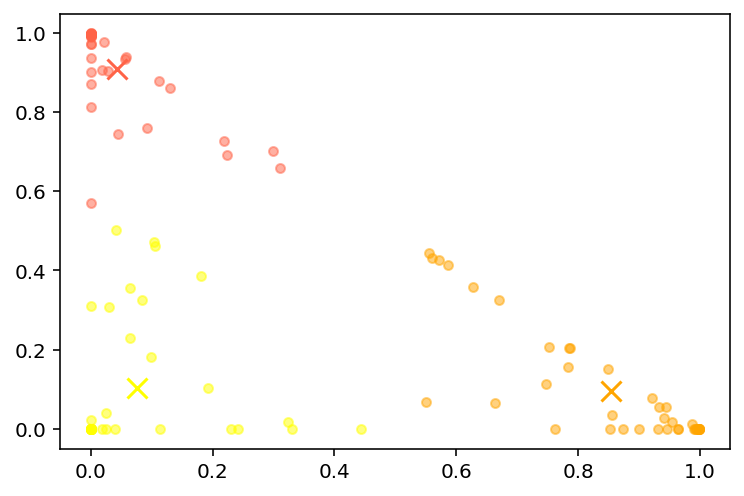

In [130]:
%matplotlib inline
num_clusters = 3 # a randomly chosen smaller number of topics based on the image above
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)

In [131]:
km.inertia_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5.897884773015256

Plotting Inertia
Plotting various inertias to see the idea number of clusters and hence topics for my data.


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


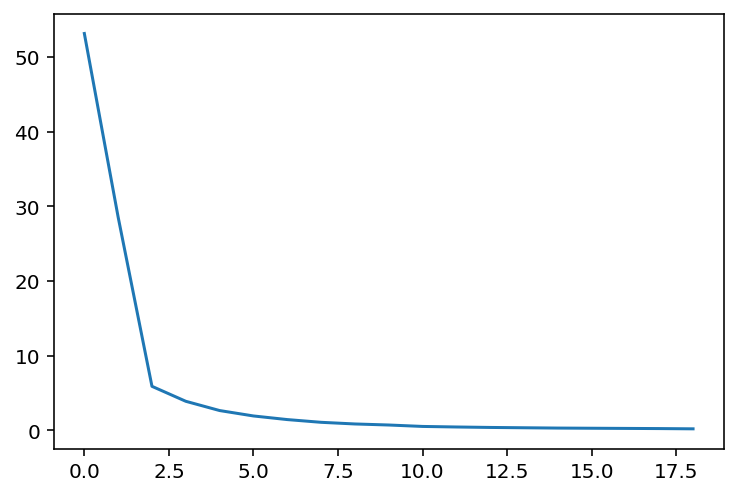

In [132]:
import matplotlib.pyplot as plt

inertias = []
for i in range(1, 20):
    km = KMeans(n_clusters=i)
    km.fit(doc_topic)
    inertia = km.inertia_
    inertias.append(inertia)

plt.plot(inertias)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


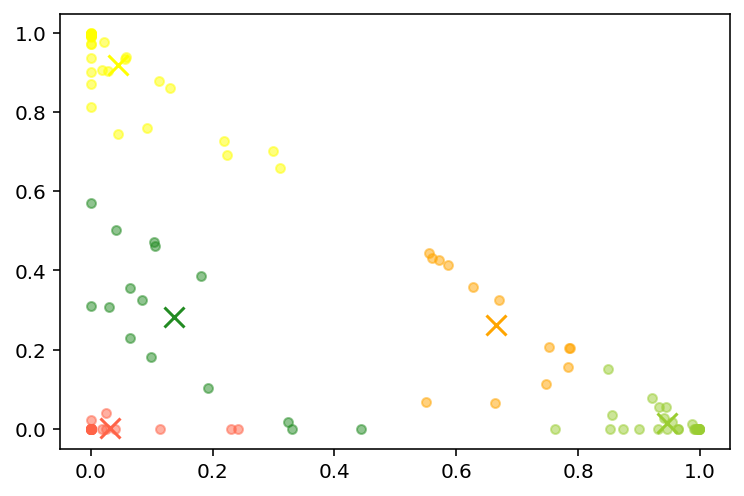

In [133]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic)
display_cluster(doc_topic, km, num_clusters)

In [134]:
km.inertia_

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.6521684506015926

Dimensionality Reduction & Visualization

See how similar or different for eadh of the seasons. Each doc has a season. Use PCA and t-SNE to reduce the doc_topic matrix's dimensions from 3  topics to 2-D space for plotting, then plot the space between all the documents. The colorization of types will then demonstrate how similar the seasons are based on their topic vectors!

In [135]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(doc_topic)
pcafeatures = pca.transform(doc_topic)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [136]:
df_nosp['season'] = df_nosp['seid'].astype(str).str[0:3]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [137]:
df_nosp["season"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11196    S04
11485    S04
11751    S04
12111    S04
12462    S04
        ... 
45813    S08
46093    S08
46387    S08
46692    S08
46979    S08
Name: season, Length: 113, dtype: object

In [138]:
target = df_nosp["season"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [139]:
target_names = list(target.unique())

print(doc_topic.shape)
print(pcafeatures.shape)

(113, 3)
(113, 2)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [140]:
print(len(pcafeatures))
print(len(target))

113
113


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [141]:
def plot_PCA(data, target, target_names):
    colors = cycle(['plum','dodgerblue', 'palegreen','red'])
    plt.figure(figsize=(10,10))
    for c, label in zip(colors, target_names):
        plt.scatter(data[target == label, 0], data[target == label, 1],
                   c=c, label=label, alpha=0.4, s=10)
    plt.legend()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


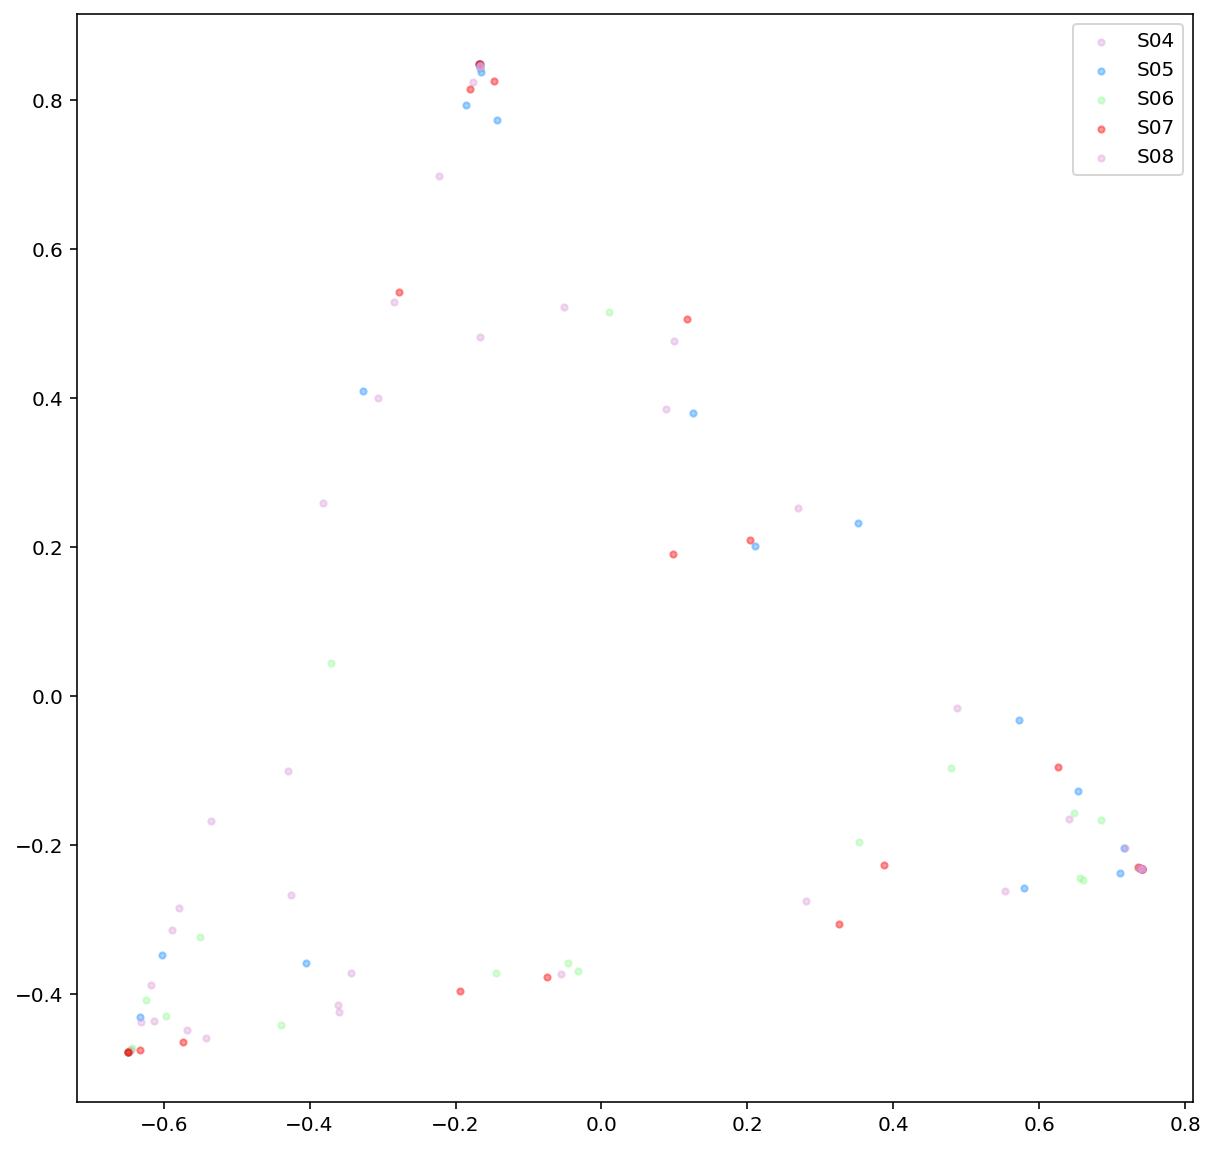

In [142]:
plot_PCA(pcafeatures, target=target, target_names=target_names)

## t-SNE 

In [790]:
tsne_model = TSNE(n_components=2, random_state=42)
tsne_data = tsne_model.fit_transform(doc_topic)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [791]:
def plot_tsne(data, target, target_names):
    colors = cycle(['plum','dodgerblue', 'palegreen','red'])
    for c, label in zip(colors, target_names):
        plt.scatter(low_data[target == label, 0], low_data[target == label, 1], c=c, label=label, s=0.4, alpha=0.5)
    plt.legend(fontsize=6, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
    plt.xlim(-100,100);



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [792]:
plot_tsne(tsne_data, target, target_names)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'low_data' is not defined

In [618]:
all_topic_words = []
for topic_id in range(lda_model.num_topics):
    topk = lda_model.show_topic(topic_id, 30)
    topk_words = [ w for w, _ in topk ]
    all_topic_words.append(topk_words)
    
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

0: key apartment show work open break listen pick glass keep year face love day buy play turn eat night whole life home mind help new meet hold bad point dog
1: work night listen eat love next second bad game person wear day test turn lot coffee open minute hit meet mind run keep number course live wrong whole read face
2: work money car book day problem listen buy eat table away pay fine thousand coffee minute love dollar point turn first keep show new check watch excuse long wear baby
3: bald hair tape coincidence listen chinese night toe house clean bad steal second hat team work english speak love side show remember watch keep day mind pick turn minute last
4: work day bad meet turn listen apartment love car run coffee movie hell new card pick night long whole away check year hold lot minute second keep enter sound eat
5: car day year minute new meet listen work lot love last first apartment dollar check help hold show drive run long away bad wear life care turn another eat keep
6:

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [619]:
all_topic_words

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['key',
  'apartment',
  'show',
  'work',
  'open',
  'break',
  'listen',
  'pick',
  'glass',
  'keep',
  'year',
  'face',
  'love',
  'day',
  'buy',
  'play',
  'turn',
  'eat',
  'night',
  'whole',
  'life',
  'home',
  'mind',
  'help',
  'new',
  'meet',
  'hold',
  'bad',
  'point',
  'dog'],
 ['work',
  'night',
  'listen',
  'eat',
  'love',
  'next',
  'second',
  'bad',
  'game',
  'person',
  'wear',
  'day',
  'test',
  'turn',
  'lot',
  'coffee',
  'open',
  'minute',
  'hit',
  'meet',
  'mind',
  'run',
  'keep',
  'number',
  'course',
  'live',
  'wrong',
  'whole',
  'read',
  'face'],
 ['work',
  'money',
  'car',
  'book',
  'day',
  'problem',
  'listen',
  'buy',
  'eat',
  'table',
  'away',
  'pay',
  'fine',
  'thousand',
  'coffee',
  'minute',
  'love',
  'dollar',
  'point',
  'turn',
  'first',
  'keep',
  'show',
  'new',
  'check',
  'watch',
  'excuse',
  'long',
  'wear',
  'baby'],
 ['bald',
  'hair',
  'tape',
  'coincidence',
  'listen',
  'ch

In [ ]:
doc_topic

In [ ]:
doc_topic.argmax(axis=1)

In [ ]:
df2['topic'] = doc_topic.argmax(axis=1)

In [ ]:
df2

## Doc: Season level

## Doc: Episode, character level

In [ ]:
epchar = df.copy()

In [ ]:
epchar = epchar.drop(['episodeno','seid','season','episodetext'],axis=1)

In [ ]:
epchar.info

**Total line counts per character (pre-clean) across all seasons**

In [ ]:
#drop_list = counter[counter['speaker'] == 'SEP'].index
#counter = counter.drop(drop_list)
epchar = epchar.groupby(['character'], as_index = False).count()
epchar = epchar.sort_values('text', ascending= False)
epchar.columns = ['character','lines count']
epchar = epchar.reset_index(drop = True)
epchar.iloc[:20]

In [ ]:
epchar2 = df.copy()

In [ ]:
epchar2 = epchar2.drop(['episodeno','seid','episodetext'],axis=1)

**Total line counts by character per season**

In [ ]:
#drop_list = counter[counter['speaker'] == 'SEP'].index
#counter = counter.drop(drop_list)
epchar2 = epchar2.groupby(['character','season'], as_index = False).count()
epchar2 = epchar2.sort_values('text', ascending= False)
epchar2.columns = ['character','season','lines_count']
epchar2 = epchar2.reset_index(drop = True)
epchar2.iloc[:20]

**Total line counts by char per season (main chars only)**

In [ ]:
nmlist = ['JERRY','GEORGE','KRAMER','ELAINE'] 
  
# selecting rows based on condition 
epchar3 = epchar2[epchar2['character'].isin(nmlist)]
epchar3

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df2.columns

**By char, what is the dist of line counts per season**

In [ ]:
plt.figure(figsize = (6, 6), facecolor = None)
#sns.set_palette("Paired")
sns.boxplot(x="character" ,y="lines_count", data=epchar3) # .iloc[:20])
plt.show()

In [ ]:
df_wide = epchar3.pivot("season","character","lines_count")
df_wide

In [ ]:
sns.lineplot(data=df_wide)

**Might need to get avg episodes per season to normalize these numbers**

**Idea: somehow get all text into one row of data per season/episode**